In [19]:
#Elis Island
#Here we are just Importing the necessary modules and
import variables as exp
import numpy as np
import scipy as sci
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd import DMDc
import matplotlib.animation as animation
import HBDMDC as mydmd
import myfunctions as myfun

#Plotting configuration
np.set_printoptions(precision=5, suppress=True)
plt.style.use('bmh')
figsize = (12, 10)
figsize2 = (12, 5)
dpi = 600    # Resolution in dots per inch

# System measurements
m = exp.m
g = exp.g
l = exp.l
t_span = exp.t_span
dt = exp.dt
b = exp.b
K = exp.K
B = exp.B
#B = np.array([[0],[1/(m*l**2)]])
nvar = int(exp.nvari)
polyorder = int(exp.order)
sineorder = int(exp.sine)
duration = 30

Above we just imputed static characteristics for the system and the linearized SS model.
The LQR derived gain is also imported as well as some of the lifting characteristics. In this specific
example we are preparing to lift the state measurements using a {{$polyorder$}}
order polynomial approximation and a {{$sineorder$}} Fourier approximation.

In [20]:
#Initial Conditions and non-linear dynamics

x0 = np.array([np.pi/4.0, 0.0])
xf = np.array([0.0,0.0])

def f(t,xk):
    x_1 = xk[1]
    x_2 = -b/m * xk[1] - g/l * np.sin(xk[0])
    ctrl = 1/(m*l**2) * u(xk)
    #print(ctrl)
    return [x_1, x_2+ctrl]


Setup of initial & terminal conditions and definition of nonlinear dynamics for the pendulum system.
Below we run an uncontrolled simulation with the initial conditions {{x0}}. This pendulum setup is undamped and should show a
cyclic behavior which we will then use to feed the DMD algorithms and find the respective Koopman Operators. We will (probably)
not use this specific data set to generate control laws for the system but we will use it as a sanity check for the fidelity
of DMD constructed systems.
u = lambda x: 0

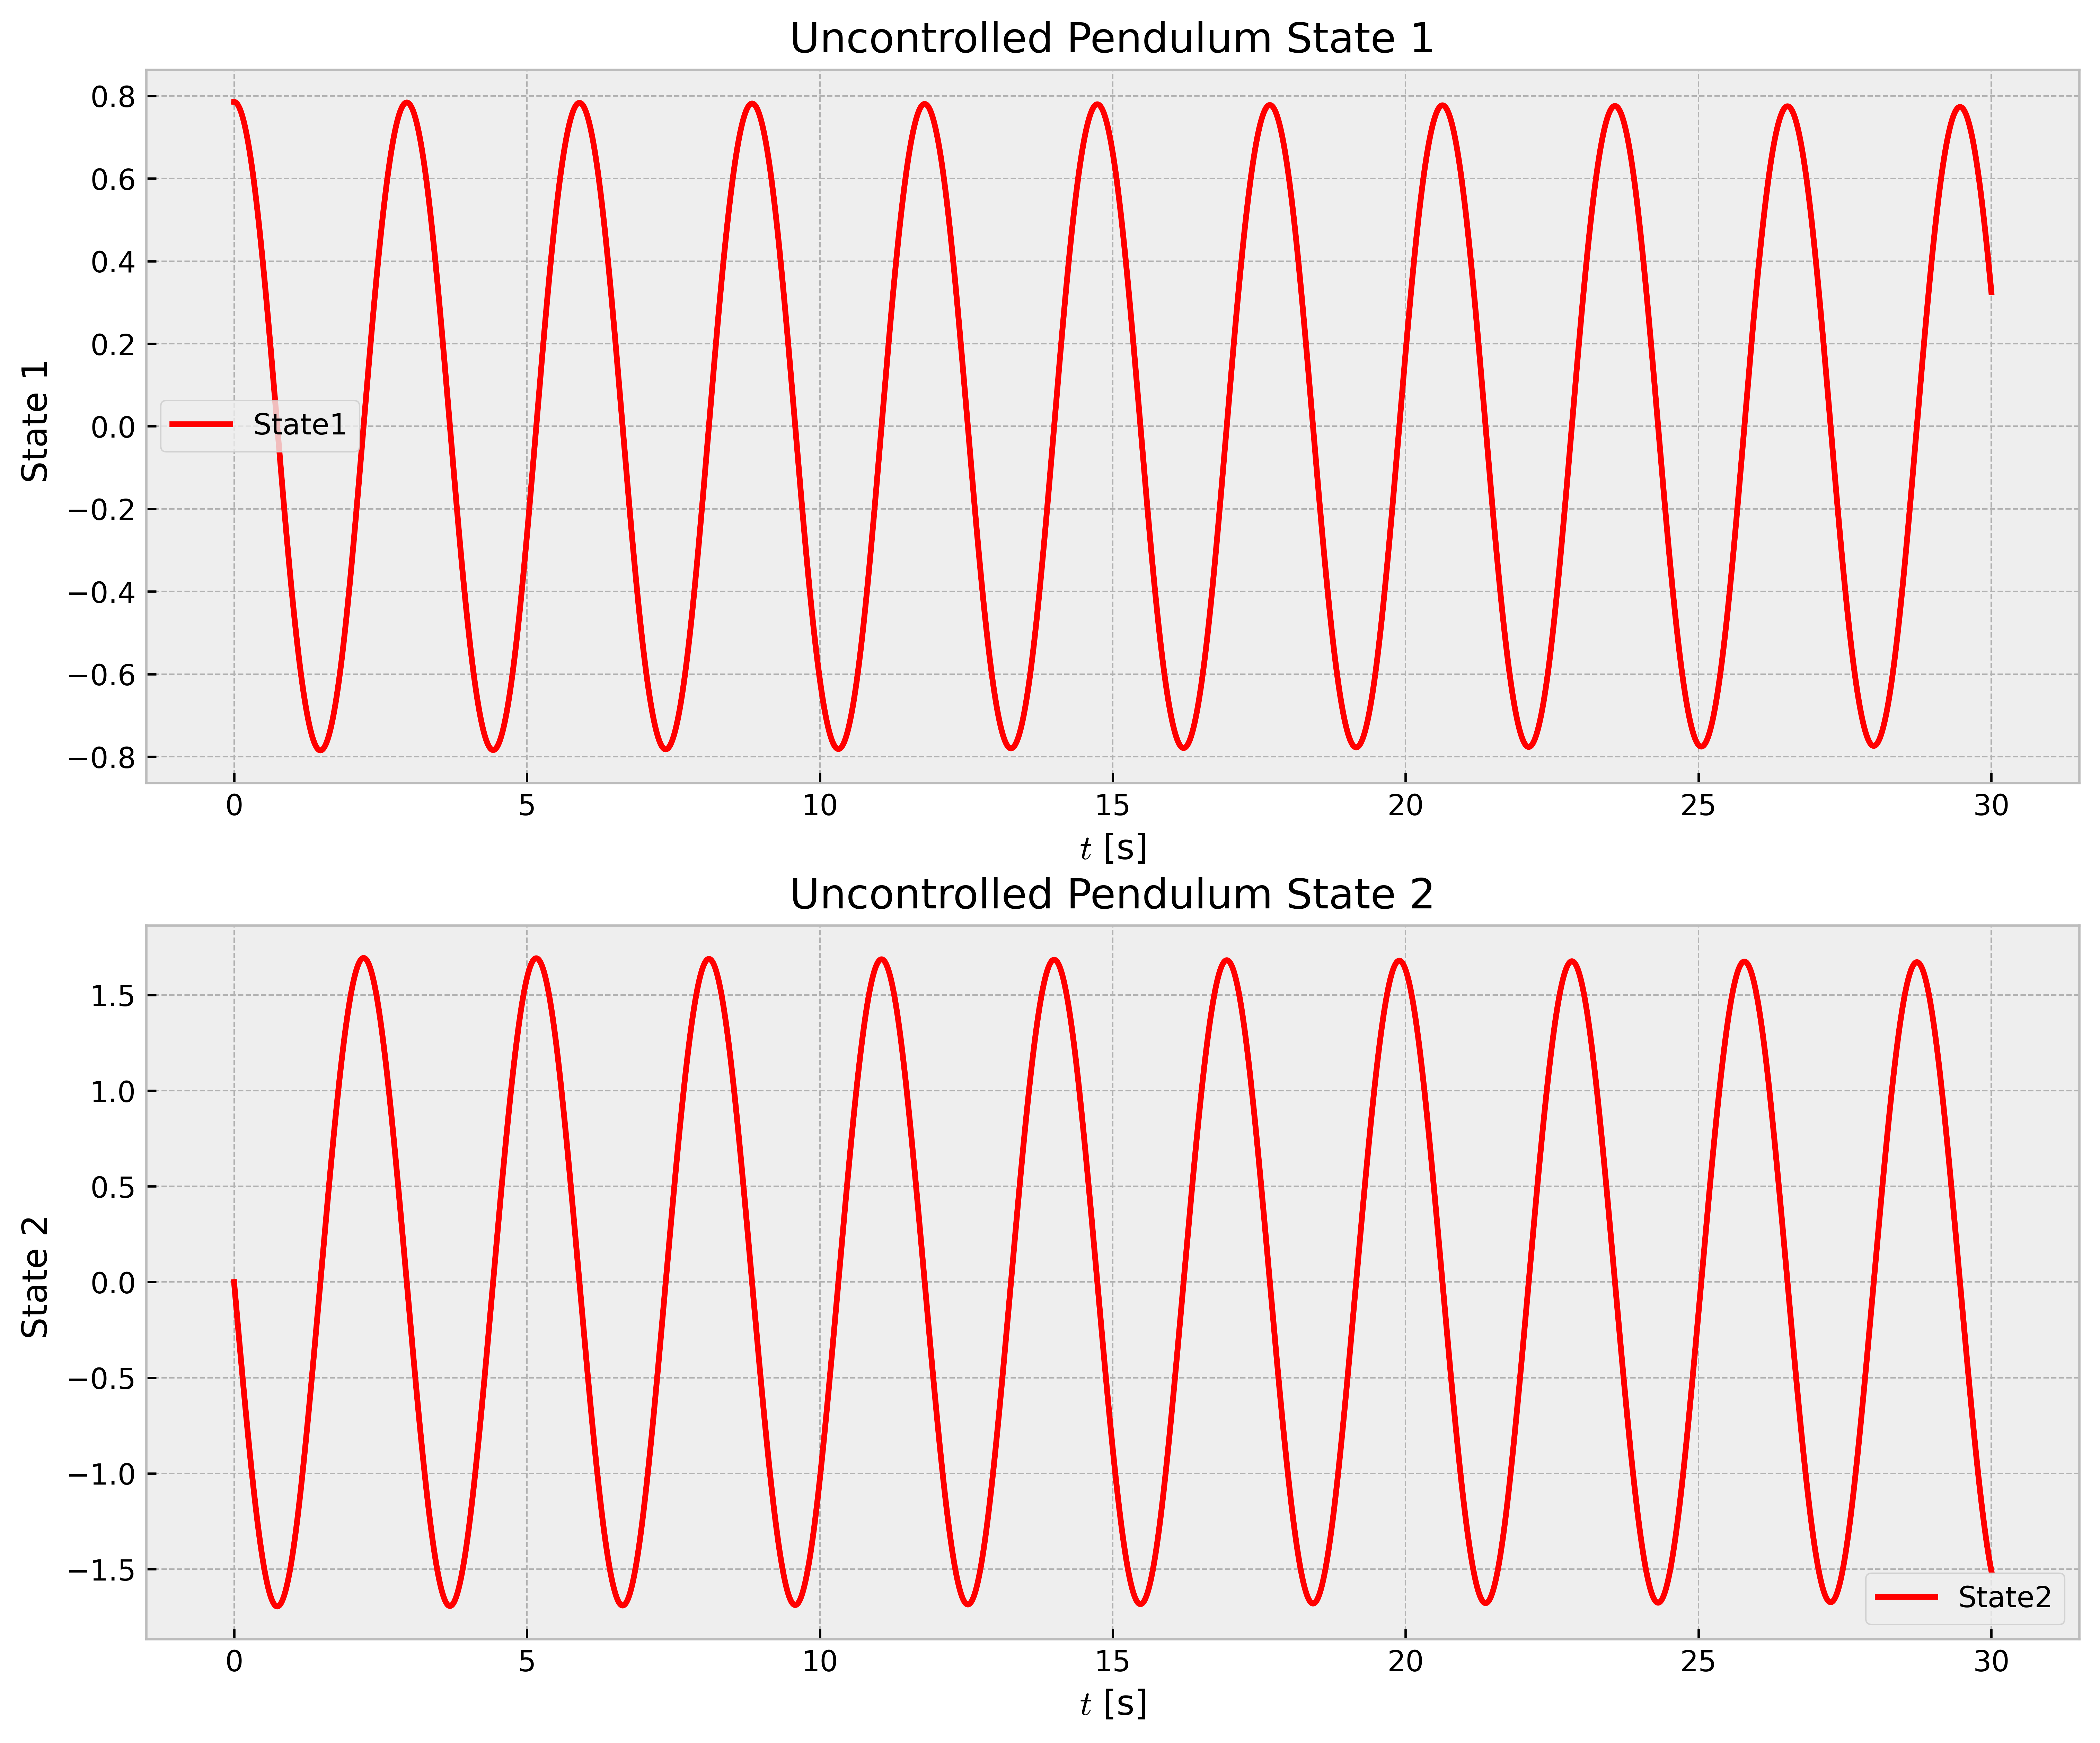

In [21]:
u = lambda x: 0
#Uncontrol Simulation
y0 = solve_ivp(f,[0.0,duration],x0,method='RK45',t_eval=t_span)
#figure

myfun.showstate(y0.y, t_span,'Uncontrolled Pendulum', figsize, dpi)

Below we generate a controlled version of the above system. In this example we will be bringing the system to a terminal state of
{{xf}}. This data will be fed through the DMD algorithms and eventually used to generate learned dynamics later.

The method we will use to control this system initially to learn the Koopman dynamics is through a Linear Quadratic Regulator [(LQR)](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator)

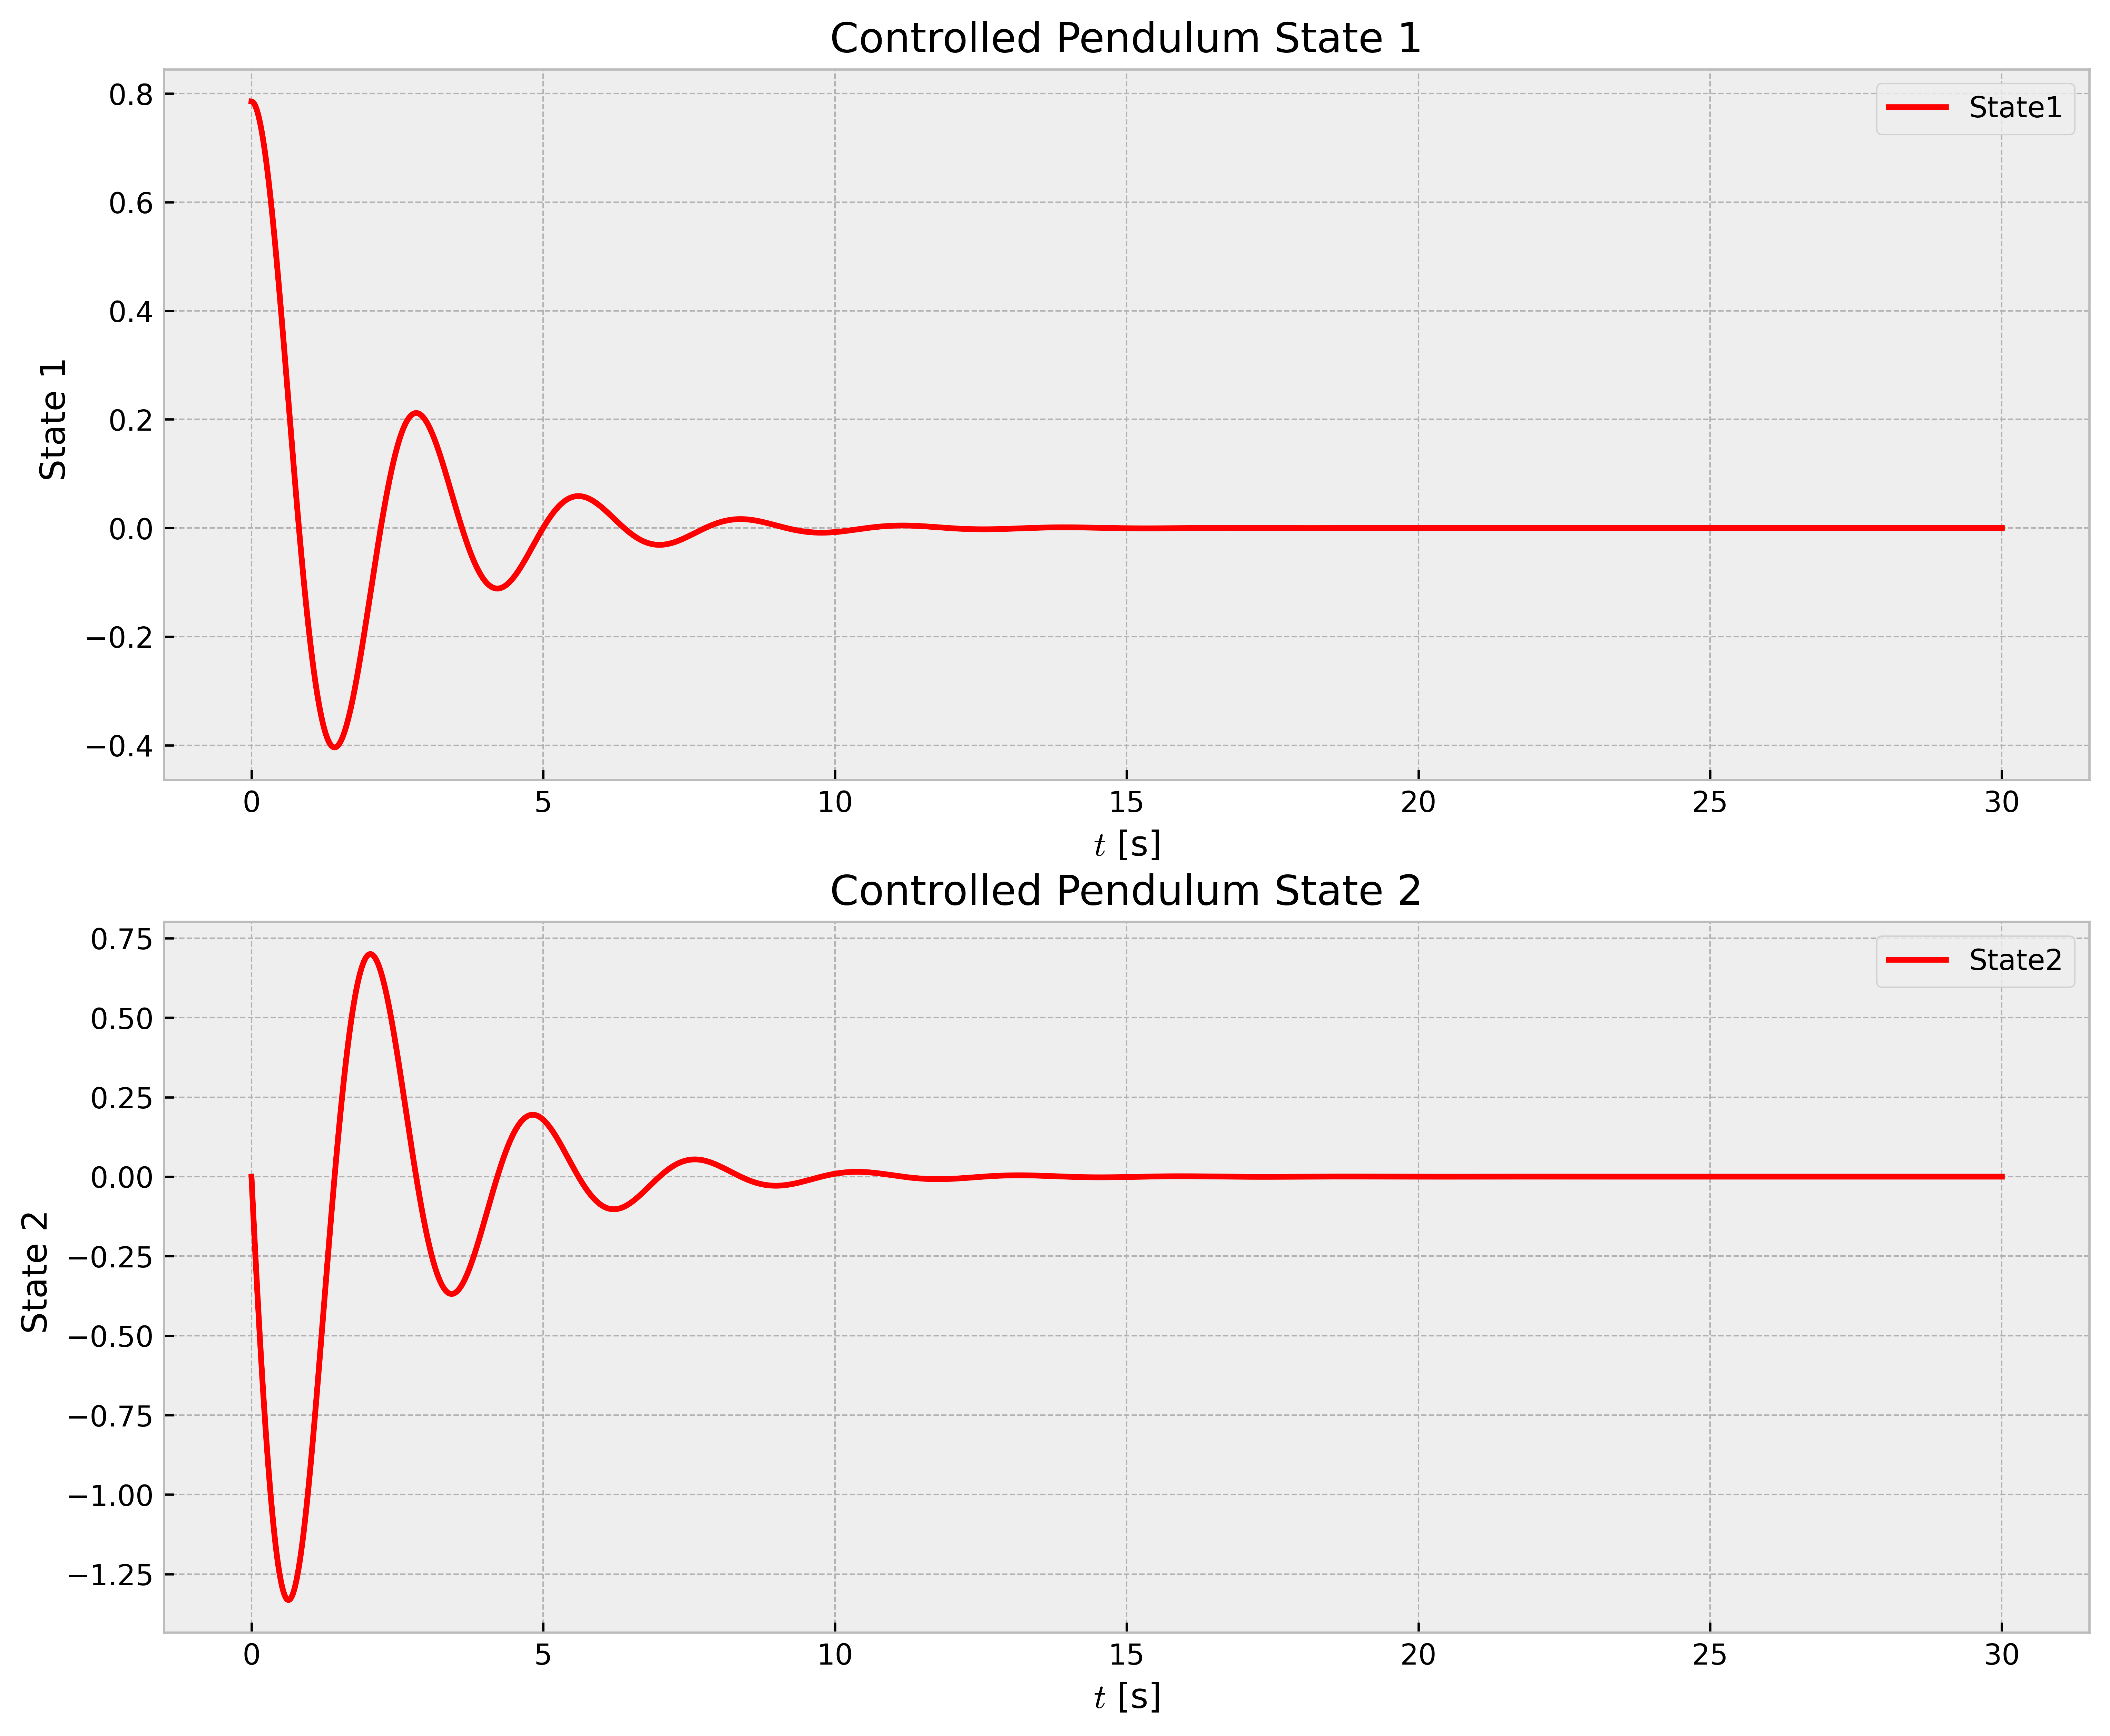

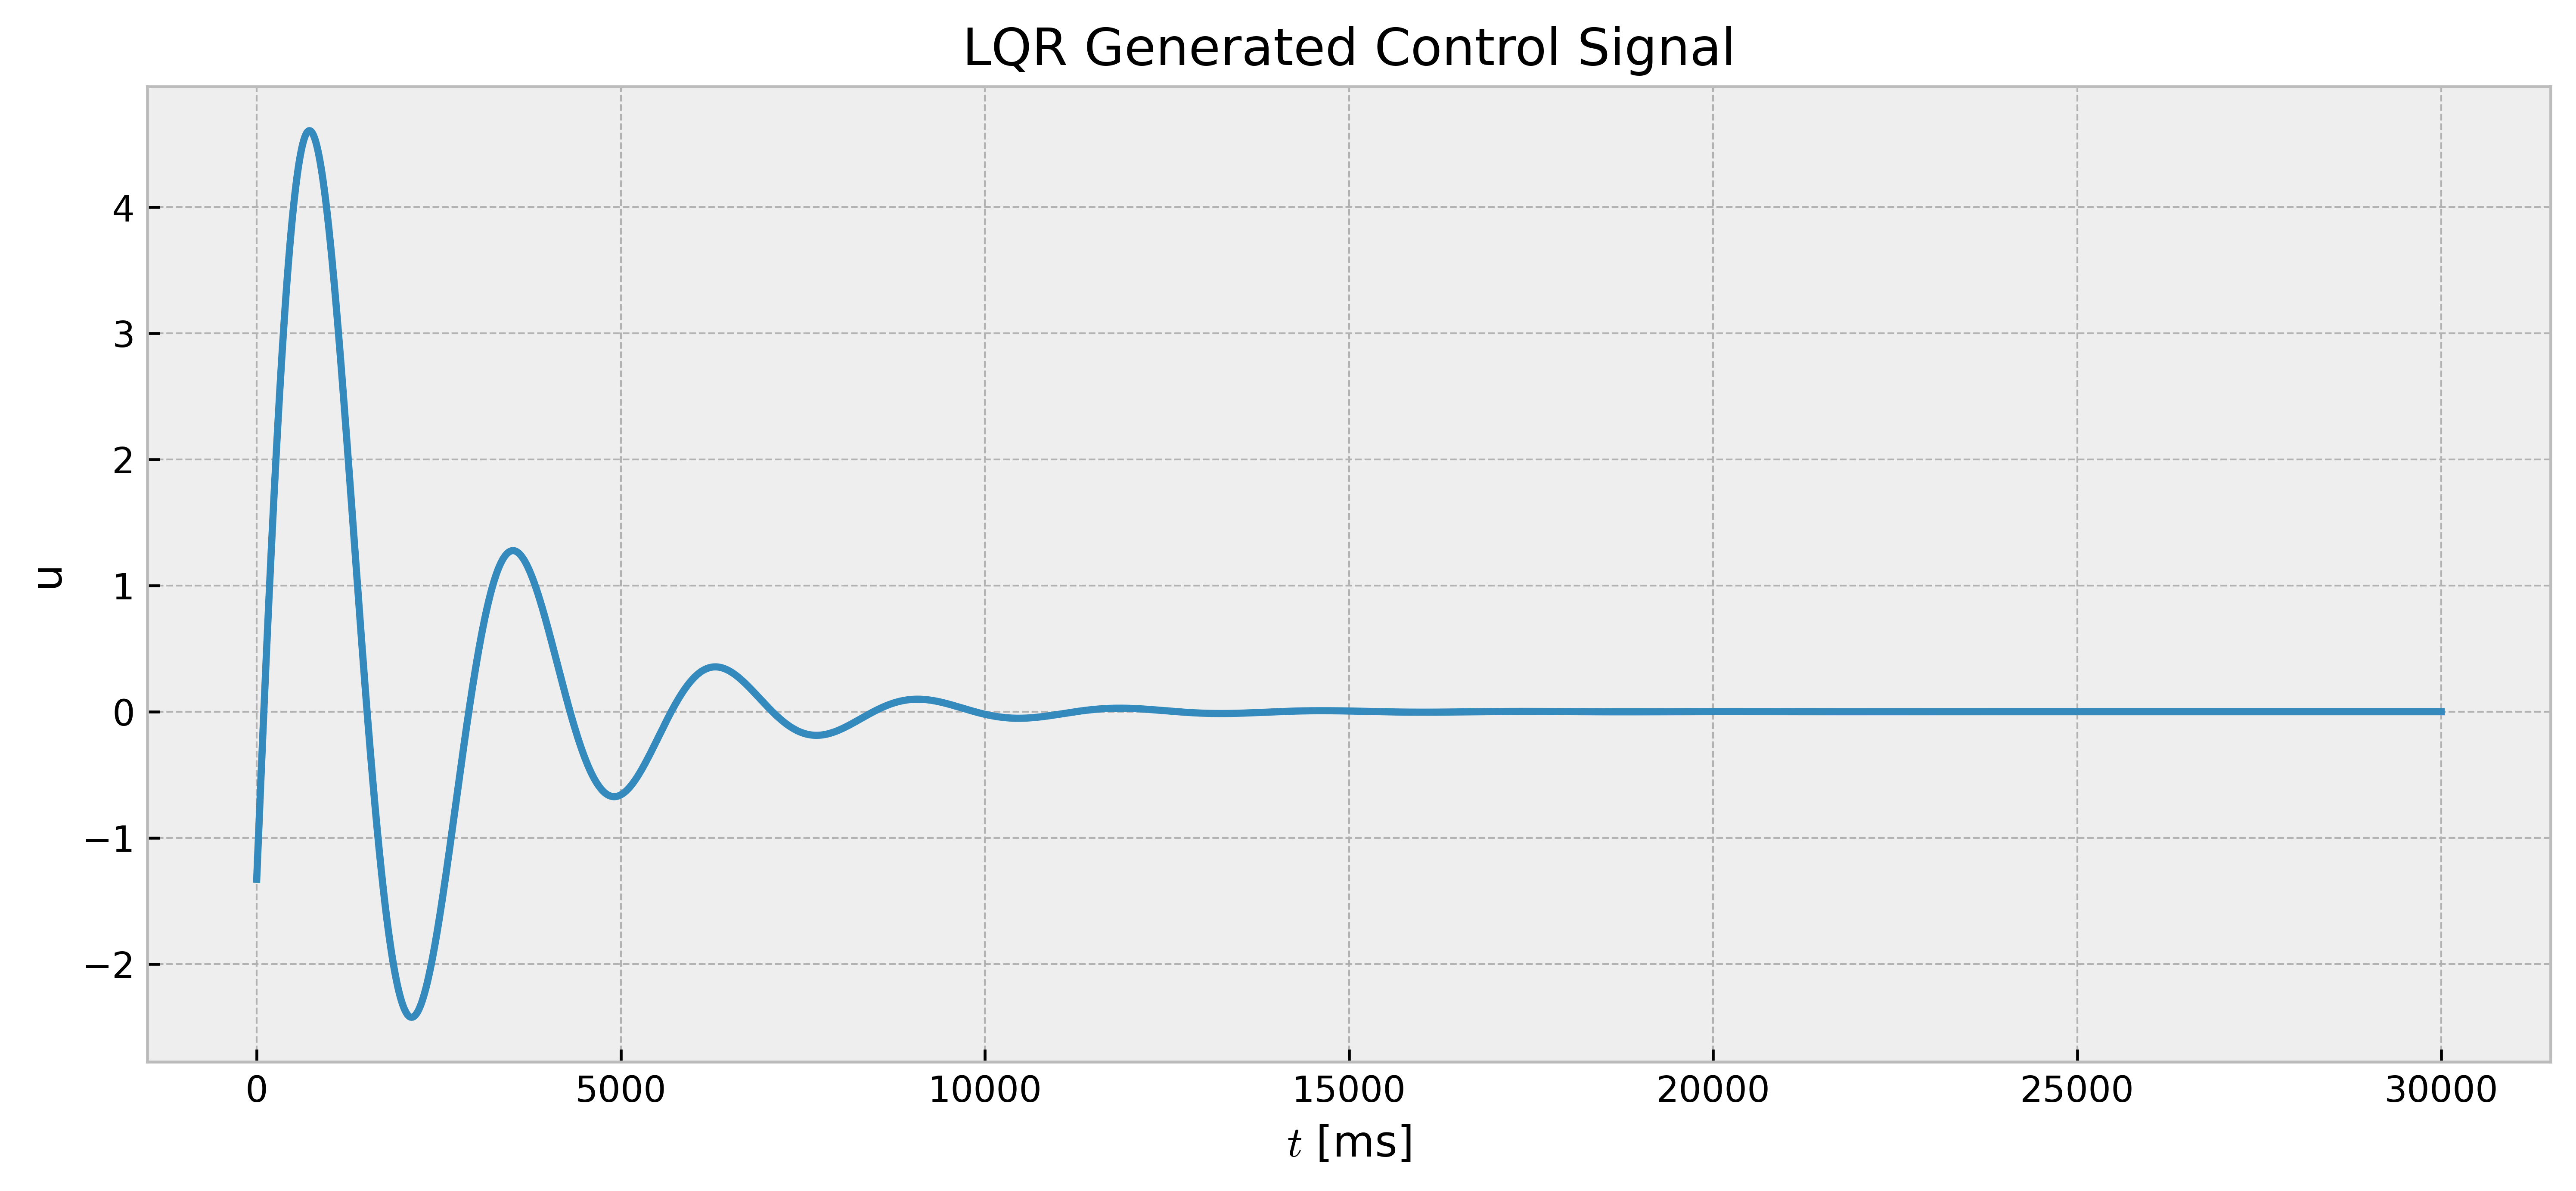

In [22]:
#Control Implementation
u = lambda x: -np.matmul(K, (x - xf))
y1 = solve_ivp(f,[0.0,duration],x0,method='RK45',t_eval=t_span)

myfun.showstate(y1.y, t_span,'Controlled Pendulum', figsize, dpi)

#recording control input

findu = y1.y
u = np.zeros(int(len(t_span)-1))
unull = np.zeros(int(len(t_span)-1))
for o in range(int(len(t_span)-1)):
    ynow = findu[:,o]
    u[o] = -np.matmul(K,(ynow-xf))
u.resize((1,int(len(t_span)-1)),refcheck=False)
unull.resize((1,int(len(t_span)-1)),refcheck=False)
plt.figure(figsize=figsize2, dpi=dpi)
plt.title("LQR Generated Control Signal")
plt.plot(u[0,:])
plt.xlabel(r"$t$ [ms]")
plt.ylabel(r"u")
plt.show()

The control is implimented via the function $u = -K(x-x_f)$ where $u$ is the control signal, $x$ is the current state, $x_f$ is the desired state and $K$ is the
gain found through LQR. The above figure is the control signal following the LQR control law imposed on the pendulum system.

Below we will use the [DMD](https://mathlab.github.io/PyDMD/index.html) algorithm to find the Koopman operator of the
uncontrolled system using the data from the non-linear model. For this run we will not be truncating the data.
<details>
<summary> DMD Algorithm </summary>
    Starting with the systems $x_{k+1} = Ax_k$ and a set of 2 consecutive snap shots $X$ and $X'$ of the format

    1. Take singular value decomposition (SVD) of $X$ <br>
        $$ \bf{\mathbf{X}} \approx U \Sigma V^* $$
        where $*$ denotees the conjugate transpose, $U \in \mathbb{R}^{n\times r}$, $\Sigma \in \mathbb{R}^{r\times r}$ and $V \in \mathbb{R}^{n\times r}$
        $r$ is the rank of the reduced SVD approximation to $X$. In SVD, the columns of $U$ are orthonormal and are POD Modes.
        > Some notes on SVD: The SVD reduction in this equation is exploited at this stage in the algorithm to perform a low-rank truncation of the data; if within the data there is a low-dimensional structure the singular values of $\Sigma$ will rapidly decrease to zero with a finite low number of dominant nodes
    2. The matrix $A$ is then found by the pseudoinverse of $X$ obtained via the SVD:
        $$ A\approx \Bar{A} =& \bf{\mathbf{X}}'\tilde{V}\tilde{\Sigma}^{-1}\tilde{U}^* $$
        Here the matrix $A\approx$ defines a "low-dimensional" linear model of the dynamical system on the POD coordinates:
        $$\tilde{\mathbf{x}}_{k+1} =& \tilde{A}\tilde{\mathbf{x}}_k $$
    3. Now perform the eigendecomposition of $A\approx$:
        $$ AW = W\mathbf{\Lambda} $$
        Here the columns of $W$ are the eigenvectors and $\Lambda$ is a diagonal matrix containing the corresponding eigenvalues
    4. This step is not so necessary to this application but for completion it will be included. To reconstruct the eigendecomposition of $A$ we will use $W$ and $\Lambda$. Since we have the eigenvalues of $A$ to find the corresponding eigenvectors of $A$ (these are the DMD modes!!) we use the folloing equation for $Phi$:
        $$\math{\Phi} =& \math{X}'\mathbf{V\Sigma}^{-1}\mathbf{W}$$


</details>

In [25]:
ybase = y0.y
#[A1, Phi1, Xdmd1] = mydmd.myDMD(ybase, 2, dt)
r=2
X1 = ybase[:, :-1]
X2 = ybase[:, 1:]
U, Sig, V = sci.linalg.svd(X2, lapack_driver='gesvd')
#U,Sig,V = np.linalg.svd(X2,full_matrices=True)
U = U[0:r, :]
sig = np.diag(Sig[:r])  # Figure out later why python stupid
V = V[0:r, :].T
Atilde = np.linalg.multi_dot([U.T.conj(),X2, V,sig ])
print(Atilde)

[Y2] = myfun.buildlinsys(A1,B, ybase[:,0], unull, t_span)
y2 = Y2.resize((len(ybase), len(ybase[1])), refcheck=False)
#myfun.comparestates(ybase,y2,t_span,'Testing','Original','Reconstructed',figsize, dpi)


[[41421.05739     0.     ]
 [    0.       9218.38597]]
